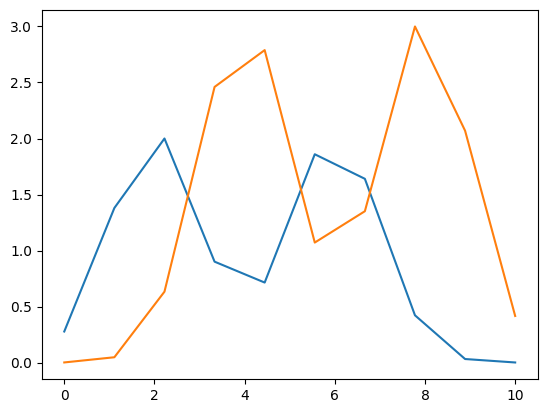

In [49]:
from simple_storage import get_multigaussian_flow
from simple_gym_pandapipes import SimpleGasStorageEnv
import pandas as pd
import matplotlib.pyplot as plt
import torch 
from torch import nn

time_index, source_flow = get_multigaussian_flow(SimpleGasStorageEnv.MAX_TIME_STEPS, [2, 6], SimpleGasStorageEnv.MAX_SOURCE_IN_FLOW)
source_flow = 100*source_flow
source_in_flow_df = pd.DataFrame(source_flow, columns = ["mdot_kg_per_s"])

# a bit delayed will be the consumption
time_index, sink_flow = get_multigaussian_flow(SimpleGasStorageEnv.MAX_TIME_STEPS, [4, 8],  SimpleGasStorageEnv.MAX_SINK_OUT_FLOW)
sink_flow = 100*sink_flow
sink_out_flow_df = pd.DataFrame(sink_flow, columns = ["mdot_kg_per_s"])

plt.plot(time_index, source_flow)
plt.plot(time_index, sink_flow)

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from simple_nn import SimpleNN

In [52]:
source_in_flow_df

,mdot_kg_per_s
0,0.277211
1,1.379844
2,2.000000
3,0.900603
4,0.714128
5,1.859375
6,1.640209
7,0.421800
8,0.031562
9,0.000687


In [53]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

def train_nnet(df : pd.DataFrame):
    # Convert to PyTorch tensors
    X = torch.tensor(df.index.values, dtype=torch.float32).view(-1, 1)
    # Scale the input feature (X)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X.numpy())
    X = torch.tensor(X, dtype=torch.float32).cuda()
    # write scaler to pickled file 
    import os, pickle 

    #plot_data_name = os.path.join(os.path.dirname(__file__), plot_data_name)
    scaler_data_name = "scaler.pl"
    with open(scaler_data_name, 'wb') as file:
        pickle.dump(scaler, file)
        
    #.cuda()  # Assuming time step is the index
    y = torch.tensor(df['mdot_kg_per_s'].values, dtype=torch.float32).view(-1, 1).cuda()
 
    # Instantiate the model, loss function, and optimizer
    model = SimpleNN().cuda()
    criterion = nn.MSELoss()  # Mean Squared Error loss for regression
    optimizer = optim.Adam(model.parameters(), lr=0.01)  # You can adjust the learning rate

    # Prepare data loader
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=len(y), shuffle=True)  # Batch size 1 since you have a small dataset

    # Training loop
    num_epochs = 10000  # You can adjust the number of epochs
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # After training, you can use the model to make predictions
    with torch.no_grad():
        predicted_values = model(X)

    # Print the predicted values
    print(predicted_values.cpu().numpy())
    return model, predicted_values.cpu()

Epoch [100/10000], Loss: 0.2160
Epoch [200/10000], Loss: 0.1953
Epoch [300/10000], Loss: 0.1952
Epoch [400/10000], Loss: 0.1952
Epoch [500/10000], Loss: 0.1952
Epoch [600/10000], Loss: 0.1952
Epoch [700/10000], Loss: 0.1952
Epoch [800/10000], Loss: 0.1952
Epoch [900/10000], Loss: 0.1952
Epoch [1000/10000], Loss: 0.1952
Epoch [1100/10000], Loss: 0.1953
Epoch [1200/10000], Loss: 0.1952
Epoch [1300/10000], Loss: 0.1952
Epoch [1400/10000], Loss: 0.1952
Epoch [1500/10000], Loss: 0.1959
Epoch [1600/10000], Loss: 0.1952
Epoch [1700/10000], Loss: 0.1952
Epoch [1800/10000], Loss: 0.1952
Epoch [1900/10000], Loss: 0.1972
Epoch [2000/10000], Loss: 0.1952
Epoch [2100/10000], Loss: 0.1952
Epoch [2200/10000], Loss: 0.1952
Epoch [2300/10000], Loss: 0.1952
Epoch [2400/10000], Loss: 0.1952
Epoch [2500/10000], Loss: 0.1952
Epoch [2600/10000], Loss: 0.1952
Epoch [2700/10000], Loss: 0.1953
Epoch [2800/10000], Loss: 0.1952
Epoch [2900/10000], Loss: 0.1952
Epoch [3000/10000], Loss: 0.1952
Epoch [3100/10000],

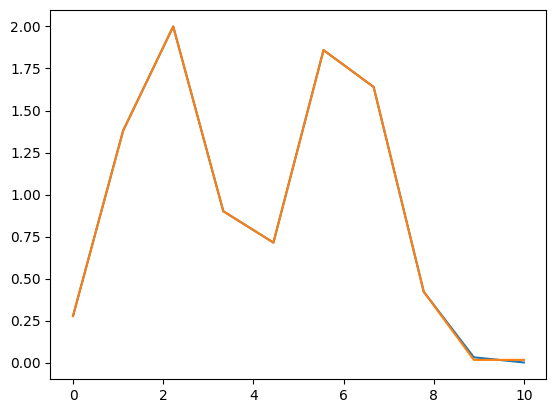

In [54]:
nnet, predictions = train_nnet(source_in_flow_df)
plt.plot(time_index, source_flow, label="Ground truth")
plt.plot(time_index, predictions, label="Predictions")
plt.show()

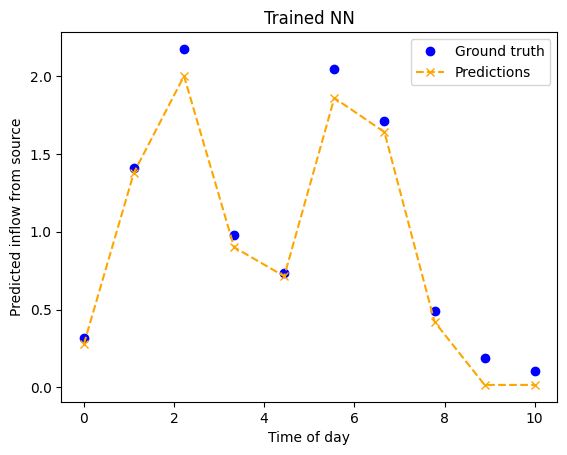

In [55]:
import numpy as np
np.random.seed(2322)
source_flow_training_data = source_flow + np.random.random(size=source_flow.shape) * 0.2
plt.plot(time_index, source_flow_training_data, "bo", label="Ground truth")
plt.plot(time_index, predictions, "x--", label="Predictions", color="orange")
plt.legend()
plt.title("Trained NN")
plt.xlabel("Time of day")
plt.ylabel("Predicted inflow from source")
plt.show()

In [56]:
torch.save(nnet.state_dict(), "trained_model.pth")


In [57]:
model = SimpleNN()
model.load_state_dict(torch.load("trained_model.pth"))
model.eval()

SimpleNN(
  (fc1): Linear(in_features=1, out_features=40, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
)